<a href="https://colab.research.google.com/github/Hannah1011/llm-response-clustering/blob/main/kmeans_experiment_merged_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
📌 [K-Means 클러스터링 실험 개선]

🔹 기존 이슈:
   - 이전 실험에서는 데이터셋이 너무 작아 K-Means가 제대로 작동하지 않았음.
   - 데이터 개수가 적을 경우, 클러스터링이 불안정해지고 분류가 제대로 이루어지지 않는 문제 발생.

🔹 개선 사항:
   - 데이터셋을 확장하여 클러스터링을 다시 진행함.
   - 데이터가 충분할 때 K-Means의 성능이 어떻게 개선되는지 분석.

✅ 이번 실험에서 데이터 증가에 따른 K-Means 성능 변화를 확인해보려고 함.
"""

In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [15]:
# Load data with embeddings
datafile_path = "/content/human_feedback_embedding_final_0221.csv"
df = pd.read_csv(datafile_path)

# Convert embeddings: string → numpy array
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
matrix.shape

(911, 192)

In [16]:
optimal_clusters =9
# # 정규화 사용한 kmeans
# scaler = StandardScaler()
# matrix = scaler.fit_transform(matrix)

kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", n_init= 50, max_iter=600, random_state=80) # 유클리드 거리 사용
kmeans.fit(matrix)
df["cluster"] = kmeans.labels_

In [17]:
df.groupby("cluster").quality.mean().sort_values()

,quality
cluster,
2,-0.388889
6,0.120000
7,0.155556
4,0.172414
3,0.291667
1,0.314815
5,0.365269
8,0.407080
0,0.538462


In [18]:
df['quality'].mean()

0.29418221734357847

In [21]:
# silhouette_values = silhouette_samples(matrix, kmeans.labels_)
# df["silhouette_value"] = silhouette_values

# # Average silhouette score for each cluster
# cluster_silhouette_avg = df.groupby("cluster")["silhouette_value"].mean()
# print("Cluster-wise Average Silhouette Scores:")
# print(cluster_silhouette_avg)

In [22]:
# # Silhouette Score
# silhouette_avg = silhouette_score(matrix, kmeans.labels_)
# print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}")
# # 초기값 : 0.17 -> 0.09 요...?

In [17]:
# from yellowbrick.cluster import SilhouetteVisualizer

# # Visualize silhouette scores
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(matrix)
# visualizer.show()

In [23]:
cluster_counts = df["cluster"].value_counts().sort_index()
print("📊 클러스터별 데이터 개수")
print(cluster_counts)

📊 클러스터별 데이터 개수
cluster
0    143
1    108
2     36
3     96
4     58
5    167
6    100
7     90
8    113
Name: count, dtype: int64


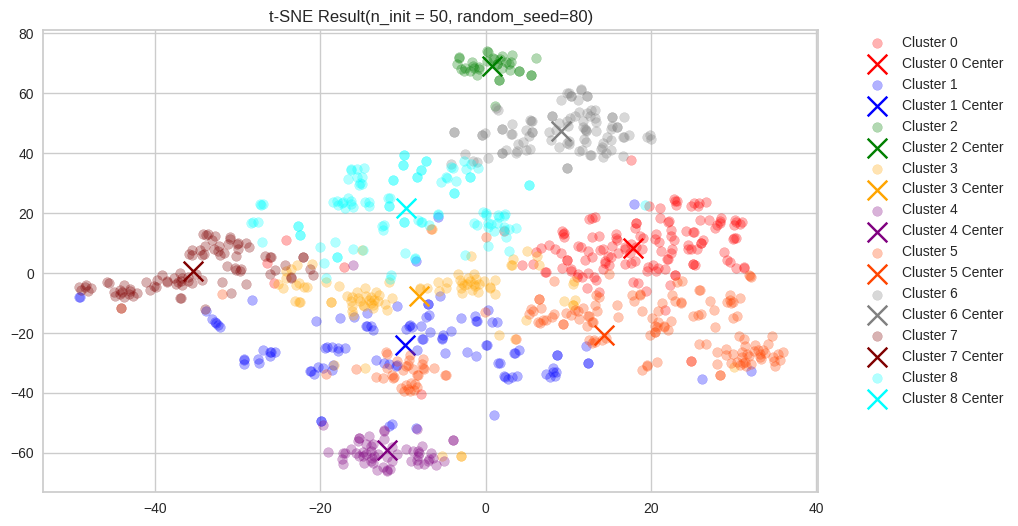

In [24]:
# t-SNE visualization (Ref : https://cookbook.openai.com/examples/clustering)
tsne = TSNE(n_components=2, perplexity=25, random_state=42, init="random", learning_rate= 300)
vis_dims2 = tsne.fit_transform(matrix)
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# vis_dims3 = tsne.fit_transform(matrix)
# x = [x for x, y, z in vis_dims3]
# y = [y for x, y, z in vis_dims3]
# z = [y for x, y, z in vis_dims3]
plt.figure(figsize=(10, 6))

colors = ["red", "blue", "green", "orange", "purple", "orangered", "gray", "maroon", "cyan"]#,"midnightblue", "teal"]
for category, color in enumerate(colors):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3, label=f"Cluster {category}")

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200, label=f"Cluster {category} Center")

plt.title("t-SNE Result(n_init = 50, random_seed=80)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [25]:
cluster_avg_quality = df.groupby("cluster").quality.mean().reset_index()
cluster_avg_quality.columns = ["cluster", "cluster_avg_quality"]
cluster_avg_quality['cluster_avg_quality'] = cluster_avg_quality['cluster_avg_quality'].round(3)
df = pd.merge(df, cluster_avg_quality, on = "cluster", how = "left")

In [170]:
df = df.drop(['cluster_avg_quality_x','cluster_avg_quality_y'],axis=1)

In [26]:
df.head(2)

,coach_no,name,quality,created_at,query,answer,guide_index,reason,reason_detail,combined,n_tokens,embedding,cluster,silhouette_value,cluster_avg_quality
0,NaN,NaN,-1,2024-12-05 13:57:09,식사 순서 바꾸기,식사 순서를 바꾸는 것은 건강한 식습관을 형성하는 데 도움이 될 수 있어요. 예를 ...,"['34', '49', '45', '42', '35', '36', '41', '32...",NaN,NaN,Query: 식사 순서 바꾸기; Answer: 식사 순서를 바꾸는 것은 건강한 식습...,396,"[0.012359867803752422, -0.06612776219844818, -...",3,0.174698,0.292
1,NaN,NaN,1,2024-12-05 14:04:59,식초 희석량,식초를 희석하여 섭취할 때는 물 200mL 이상에 식초를 섞어 드시는 것이 좋습니다...,"['59', '67', '61', '62', '57', '65', '60', '58...",NaN,NaN,Query: 식초 희석량; Answer: 식초를 희석하여 섭취할 때는 물 200mL...,421,"[0.0867302268743515, -0.1243383064866066, -0.0...",4,0.263831,0.172


In [27]:
output_path = "./human_feedback_ver2_192_9_clustering_0221.csv"
column_needed = ["coach_no","name", "quality", "created_at", "query",	"answer","combined", "guide_index","reason", "reason_detail","n_tokens","cluster",	"cluster_avg_quality"]
df.to_csv(output_path, columns = column_needed, index= False)

In [28]:
pd.read_csv(output_path)

,coach_no,name,quality,created_at,query,answer,combined,guide_index,reason,reason_detail,n_tokens,cluster,cluster_avg_quality
0,NaN,NaN,-1,2024-12-05 13:57:09,식사 순서 바꾸기,식사 순서를 바꾸는 것은 건강한 식습관을 형성하는 데 도움이 될 수 있어요. 예를 ...,Query: 식사 순서 바꾸기; Answer: 식사 순서를 바꾸는 것은 건강한 식습...,"['34', '49', '45', '42', '35', '36', '41', '32...",NaN,NaN,396,3,0.292
1,NaN,NaN,1,2024-12-05 14:04:59,식초 희석량,식초를 희석하여 섭취할 때는 물 200mL 이상에 식초를 섞어 드시는 것이 좋습니다...,Query: 식초 희석량; Answer: 식초를 희석하여 섭취할 때는 물 200mL...,"['59', '67', '61', '62', '57', '65', '60', '58...",NaN,NaN,421,4,0.172
2,NaN,NaN,1,2024-12-05 20:08:26,단식후 신경 안쓰고 먹었는데 신경써야하는게 있나요?,단식 후에는 식사에 신경을 쓰는 것이 중요합니다. 단식 후 무분별하게 음식을 섭취하...,Query: 단식후 신경 안쓰고 먹었는데 신경써야하는게 있나요?; Answer: 단...,"['112', '120', '122', '54', '242', '106', '117...",NaN,NaN,390,7,0.156
3,NaN,NaN,1,2024-12-06 11:53:34,식이섬유가 많이 들어간 국물을 추천해줘,식이섬유가 많이 들어간 국물 요리를 추천드릴게요. 미역국은 식이섬유가 풍부한 해조류...,Query: 식이섬유가 많이 들어간 국물을 추천해줘; Answer: 식이섬유가 많이...,"['15', '167', '53', '28', '27', '75', '247', '...",NaN,NaN,444,1,0.315
4,NaN,NaN,1,2024-12-06 13:08:55,"나가사키짬뽕,유린기,고추잡채,과일사라다를 먹고 혈당스파이크가 발생한 이유를 말해줘\...","혈당 스파이크는 식사 후 혈당이 급격히 상승했다가 떨어지는 현상으로, 나가사키짬뽕,...","Query: 나가사키짬뽕,유린기,고추잡채,과일사라다를 먹고 혈당스파이크가 발생한 이...","['10', '185', '184', '153', '148', '26', '250'...",NaN,NaN,534,0,0.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,217.0,NaN,1,2025-02-21 10:34:45,아침에 혈당을 측정했을 때 혈당이 상승한 이유가 뭘까요?,"이른 아침에 혈당이 상승하는 현상은 '새벽현상'이라고 불리며, 이는 우리 몸의 호르...",Query: 아침에 혈당을 측정했을 때 혈당이 상승한 이유가 뭘까요?; Answer...,"['guide_149', 'guide_253', 'guide_254', 'guide...",Good,응답이 정확합니다.,506,0,0.538
907,218.0,NaN,1,2025-02-21 10:34:50,껌을 씹어도 혈당에 괜찮을까요?,껌을 씹는 것은 일반적으로 혈당에 큰 영향을 미치지 않아요. 대부분의 껌은 설탕 대...,Query: 껌을 씹어도 혈당에 괜찮을까요?; Answer: 껌을 씹는 것은 일반적...,"['guide_12', 'guide_5', 'guide_178', 'guide_25...",Good,응답이 정확합니다.,404,5,0.365
908,219.0,NaN,1,2025-02-21 10:34:54,수면 중 저혈당이 너무 자주 나타나요. 정상인가요?,수면 중 저혈당이 자주 나타나는 것은 흔히 발생할 수 있는 일입니다. 센서로 측정한...,Query: 수면 중 저혈당이 너무 자주 나타나요. 정상인가요?; Answer: 수...,"['guide_159', 'guide_263', 'guide_144', 'guide...",Good,응답이 정확합니다.,390,0,0.538
909,220.0,남궁서연,1,2025-02-21 10:34:59,안먹었을 때가 더 살도 잘 빠지고 배도 안고픈 것 같아요저랑 웰다는 맞지 않는 것 ...,"무작정 식사를 줄이는 다이어트는 처음에는 체중이 줄어드는 것처럼 보일 수 있지만, ...",Query: 안먹었을 때가 더 살도 잘 빠지고 배도 안고픈 것 같아요저랑 웰다는 맞...,"['guide_2', 'base_37', 'guide_154', 'guide_290...",Good,응답이 정확합니다.,430,8,0.407
